In [83]:
import pystan
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
multiprocessing.set_start_method("fork", force=True)

from orbit.utils.stan import get_compiled_stan_model_simplified, compile_stan_model_simplified
from orbit.utils.dataset import load_iclaims
import arviz as az

In [84]:
ss_model_path = "./stan/ss_local_level_reg.stan"
compiled_path = compile_stan_model_simplified(ss_model_path)
ss_mod = get_compiled_stan_model_simplified(compiled_path)
del compiled_path

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3ca429b361f9437ab1eea335f0abd6a4 NOW.
In file included from /var/folders/g0/77v1jc9s455cj14mkqcht0m00000gn/T/pystan_hyr199dv/stanfit4anon_model_3ca429b361f9437ab1eea335f0abd6a4_643060139660307632.cpp:788:
In file included from /Users/towinazure/opt/miniconda3/envs/ts/lib/python3.8/site-packages/numpy/core/include/numpy/arrayobject.h:4:
In file included from /Users/towinazure/opt/miniconda3/envs/ts/lib/python3.8/site-packages/numpy/core/include/numpy/ndarrayobject.h:12:
In file included from /Users/towinazure/opt/miniconda3/envs/ts/lib/python3.8/site-packages/numpy/core/include/numpy/ndarraytypes.h:1969:
/Users/towinazure/opt/miniconda3/envs/ts/lib/python3.8/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: "Using deprecated NumPy API, disable it with "          "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-W#warnings]
#warning "Using deprecated NumPy API, disable it with " \
 ^
In file included

In [85]:
# fake data
# np.random.seed(2022)
# x = np.random.normal(0, 0.2, 100)
# y = np.cumsum(x) + np.random.normal(0, 1.0, 100)
# y = (y - np.mean(y))/np.std(y)

In [86]:
raw_data = load_iclaims()
y = raw_data['claims']
y = (y - np.mean(y))/np.std(y)

In [87]:
def make_fourier_series(n, period, order=3, shift=0):
    t = np.arange(1, n + 1) + shift
    out = list()
    for i in range(1, order + 1):
        x = 2.0 * i * np.pi * t / period
        out.append(np.cos(x))
        out.append(np.sin(x))
    out = np.column_stack(out)
    return out

In [116]:
intercept_reg = np.ones((len(y), 1))
fs_reg = make_fourier_series(len(y), 52, order=3)
xreg = np.concatenate([intercept_reg, fs_reg], -1)
m = xreg.shape[1]
a1 = np.array([y[1]] + [0.0] * (m-1))
p1 = np.zeros_like(a1)

In [117]:
data = {
    'N': len(y),
    'M': m,
    'Y' : y,
    'XREG' : xreg,
    'SD_Y' : 1.0,
    'A1' : a1,
    'P1' : p1,
    'STATE_SIGMA_MEAN': np.ones(m) * 0.1,
    'STATE_SIGMA_SD': np.ones(m),
    'OBS_SIGMA_MEAN': 0.8,
    'OBS_SIGMA_SD': 1.0,
}

In [118]:
ss_fit = ss_mod.sampling(
    data=data,
    warmup=3000,
    iter=4000,
    chains=4,
)


Gradient evaluation took 0.001349 seconds
1000 transitions using 10 leapfrog steps per transition would take 13.49 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.001388 seconds
1000 transitions using 10 leapfrog steps per transition would take 13.88 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 4000 [  0%]  (Warmup)

Gradient evaluation took 0.001306 seconds
1000 transitions using 10 leapfrog steps per transition would take 13.06 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.001322 seconds
1000 transitions using 10 leapfrog steps per transition would take 13.22 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 4000 [  0%]  (Warmup)
Iteration:    1 / 4000 [  0%]  (Warmup)
Iteration:    1 / 4000 [  0%]  (Warmup)
Iteration:  400 / 4000 [ 10%]  (Warmup)
Iteration:  400 / 4000 [ 10%]  (Warmup)
Iteration:  400 / 4000 [ 10%]  (Warmup)
Iteration:  400 / 4000 [ 10%]  (Warmup)
Iteration:  800 / 40

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


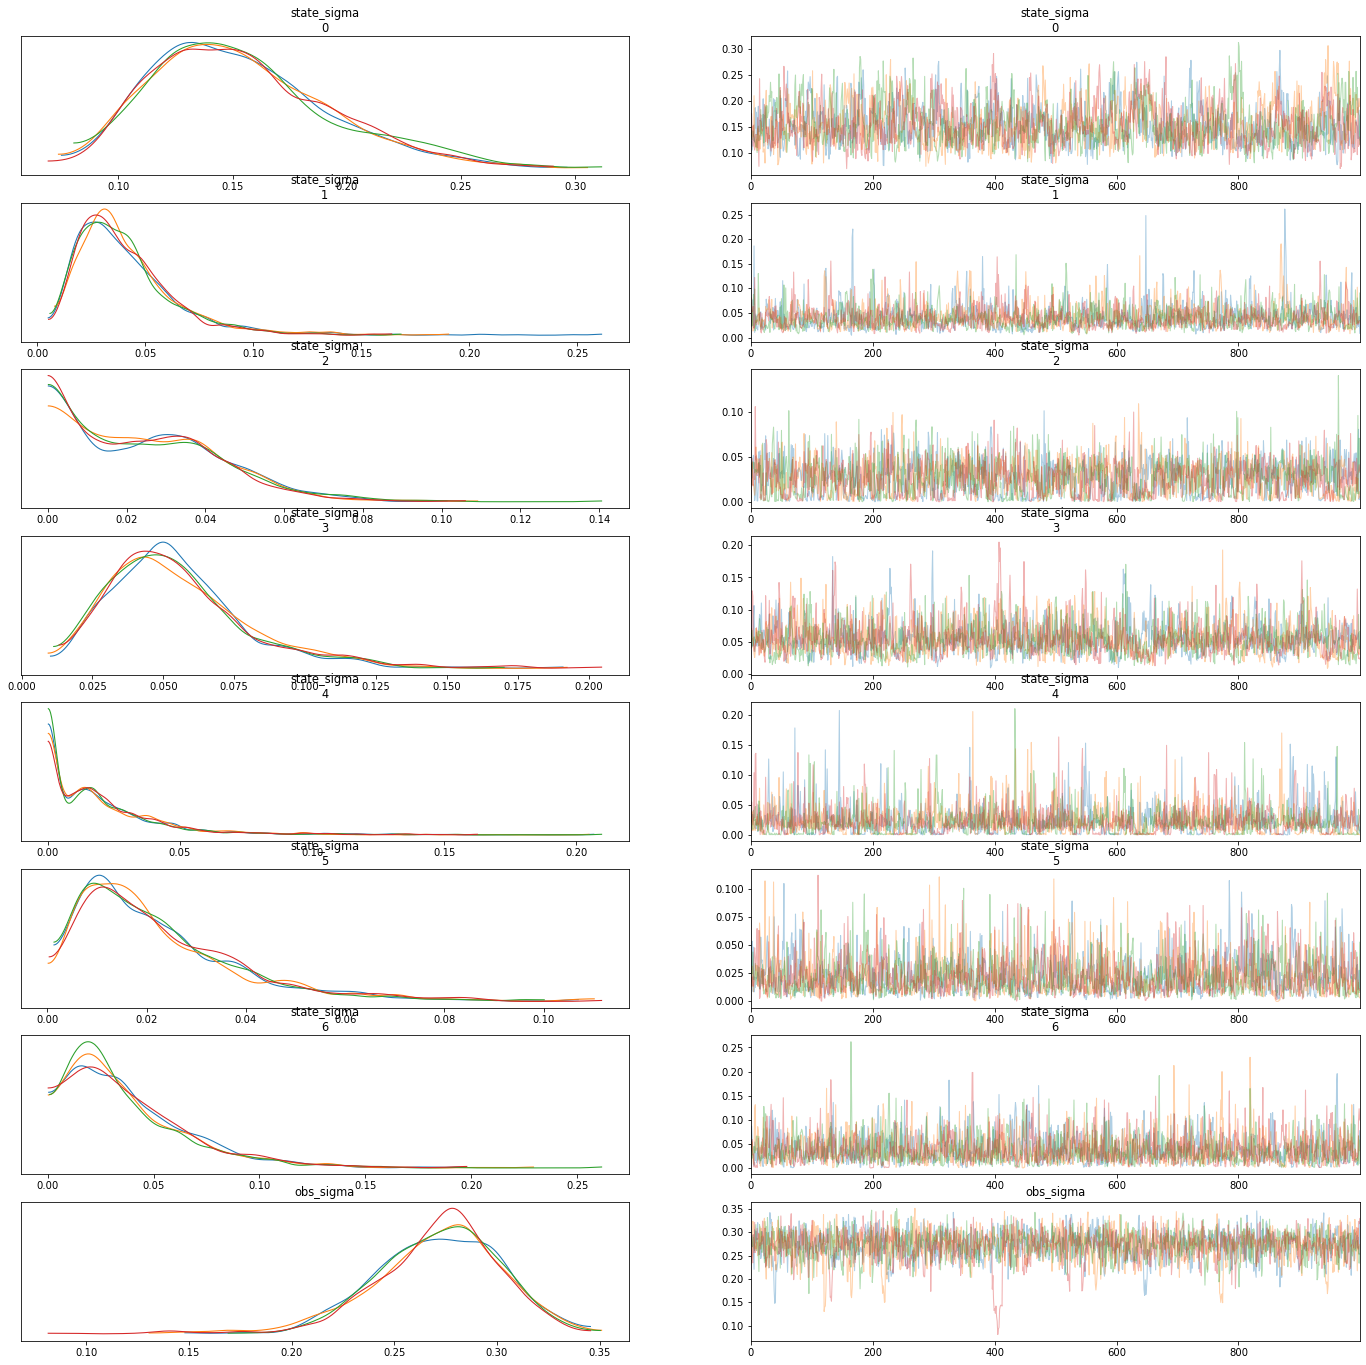

In [119]:
az_posteriors = az.from_pystan(ss_fit)
az.plot_trace(az_posteriors, var_names=['state_sigma', 'obs_sigma'], compact=False, figsize=(24, 24));

In [133]:
ss_posteriors = ss_fit.extract(pars=['state_sigma', 'states', 'obs_sigma','a'], permuted=True)
states = ss_posteriors['states']
states.shape

(4000, 444, 7)

In [140]:
yhat = np.sum(states[:, :-1, :] * np.expand_dims(xreg, 0), -1)
yhat_upper, yhat_med, yhat_lower = np.quantile(yhat, q=[0.9, 0.5, 0.1], axis=0)

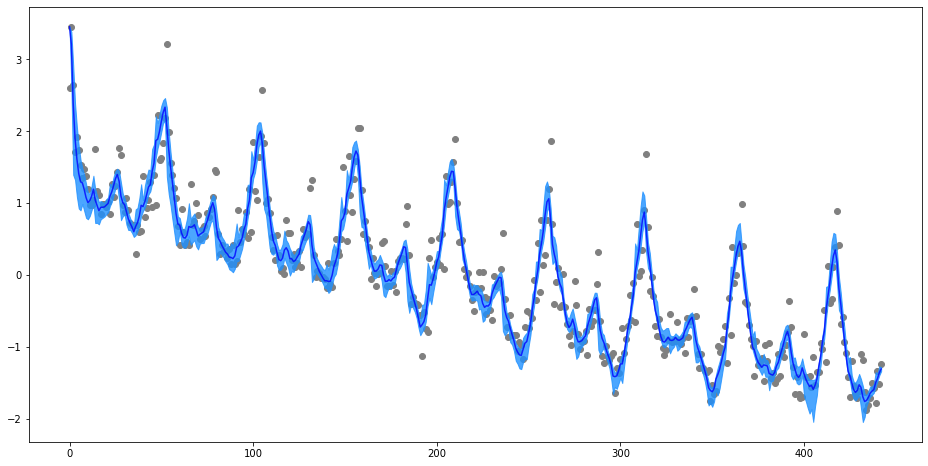

In [144]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
x = np.arange(0, len(y))
ax.scatter(x, y, c='grey')
ax.plot(x, yhat_med, color='blue', alpha=0.8);
ax.fill_between(x=x, y1=yhat_lower, y2=yhat_upper, color='dodgerblue', alpha=0.8);

In [ ]:
walker_model_path = "./stan/walker.stan"
compiled_path = compile_stan_model_simplified(walker_model_path)
walker_mod = get_compiled_stan_model_simplified(compiled_path)
del compiled_path

In [ ]:
data = {
    'n' : len(y),
    'k' : 1,
    'xreg' : np.ones((1, len(y))),
    'y': y,
    'beta_mean' : np.zeros((1)),
    'beta_sd' : np.ones((1)),
    'sigma_mean': np.ones((2, )),
    'sigma_sd': np.ones((2, )),
    'n_new': 0,
    'xreg_new': np.ones((1, 0)),
}

In [ ]:
walker_fit = walker_mod.sampling(
    data=data,
    warmup=4000,
    iter=5000,
    chains=4,
)


Gradient evaluation took 0.001652 seconds
1000 transitions using 10 leapfrog steps per transition would take 16.52 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.001507 seconds
1000 transitions using 10 leapfrog steps per transition would take 15.07 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.001309 seconds
1000 transitions using 10 leapfrog steps per transition would take 13.09 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.001273 seconds
1000 transitions using 10 leapfrog steps per transition would take 12.73 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 5000 [  0%]  (Warmup)
Iteration:    1 / 5000 [  0%]  (Warmup)
Iteration:    1 / 5000 [  0%]  (Warmup)
Iteration:    1 / 5000 [  0%]  (Warmup)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: Exception: multiply: A[1] is nan, but must not be nan!  (in 'unknown file name' at line 19)
  (in 'unknown file name' at line 99)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: Exception: multiply: A[1] is nan, but must not be nan!  (in 'unknown file name' at line 19)
  (in 'unknown file name' at line 99)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informationa

Iteration:  500 / 5000 [ 10%]  (Warmup)
Iteration:  500 / 5000 [ 10%]  (Warmup)
Iteration:  500 / 5000 [ 10%]  (Warmup)
Iteration:  500 / 5000 [ 10%]  (Warmup)
Iteration: 1000 / 5000 [ 20%]  (Warmup)
Iteration: 1000 / 5000 [ 20%]  (Warmup)
Iteration: 1000 / 5000 [ 20%]  (Warmup)
Iteration: 1000 / 5000 [ 20%]  (Warmup)
Iteration: 1500 / 5000 [ 30%]  (Warmup)
Iteration: 1500 / 5000 [ 30%]  (Warmup)
Iteration: 1500 / 5000 [ 30%]  (Warmup)
Iteration: 1500 / 5000 [ 30%]  (Warmup)
Iteration: 2000 / 5000 [ 40%]  (Warmup)
Iteration: 2000 / 5000 [ 40%]  (Warmup)
Iteration: 2000 / 5000 [ 40%]  (Warmup)
Iteration: 2000 / 5000 [ 40%]  (Warmup)
Iteration: 2500 / 5000 [ 50%]  (Warmup)
Iteration: 2500 / 5000 [ 50%]  (Warmup)
Iteration: 2500 / 5000 [ 50%]  (Warmup)
Iteration: 2500 / 5000 [ 50%]  (Warmup)
Iteration: 3000 / 5000 [ 60%]  (Warmup)
Iteration: 3000 / 5000 [ 60%]  (Warmup)
Iteration: 3000 / 5000 [ 60%]  (Warmup)
Iteration: 3000 / 5000 [ 60%]  (Warmup)
Iteration: 3500 / 5000 [ 70%]  (Warmup)


Iteration: 5000 / 5000 [100%]  (Sampling)

 Elapsed Time: 26.4267 seconds (Warm-up)
               7.66955 seconds (Sampling)
               34.0962 seconds (Total)



In [ ]:
az_posteriors = az.from_pystan(walker_fit)
# converging
az.plot_trace(az_posteriors, var_names=['sigma_b', 'sigma_y'], compact=False, figsize=(24, 12));

In [ ]:
posteriors = walker_fit.extract(permuted=True)

In [ ]:
states_mean = posteriors['y_rep']
states_mean = np.mean(states_mean, 0)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
x = np.arange(0, len(y))
ax.scatter(x, y, c='grey')
ax.plot(x, states_mean, color='blue');